In [ ]:
"""
Produce a CMB map from 6 frequencies (27, 39, 93, 145, 225, 278). 
Foregrounds: 
1. Lensed CMB + Extragalactic (tSZ, kSZ, CIB) from Yuuki.
2. Extragalctic radio from G15.
##3. Polarised extagalactic = T * pol_fraction fiven in params_ilc_with_simulated_skies.ini (yet to be included).
4. Galactic foregrounds comes from Caterina Umilta.
Covariance: Computed on the fly from the simulated skies.
"""

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
try:
    import os
    rc('text.latex',preamble=r'\usepackage{%s/apjfonts}' %(str(os.getcwd())))
except:
    pass

In [3]:
import argparse, sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
#or look into https://github.com/sriniraghunathan/tools
import flatsky, tools, misc
import ilc, foregrounds as fg

import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [4]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [5]:
#params
paramfile = 'params_ilc_with_simulated_skies.ini'
freqarr = [27, 39, 93, 145, 225, 278]

#https://docs.google.com/spreadsheets/d/1Q76Il6g33PeNhQEv1xkHe3PWpomxBPRcC7wgp7TQfus/edit#gid=26429016
beamarr= [7.4, 5.1, 2.2, 1.4, 1.0, 0.9] 

#S4 atmospheric and instrumental noise values 
#(https://cmb-s4.org/wiki/index.php/Expected_Survey_Performance_for_Science_Forecasting#DSR_Reference_Design)

noisearr_T = [7.3, 5.5, 2.0, 2.0, 6.9, 16.7]
elkneearr_T = [471., 428., 2154., 4364., 7334., 7308.]
alphakneearr_T = [3.5, 3.5, 3.5, 3.5, 3.5, 3.5]
noisearr_P = [30.8, 17.6, 2.9, 2.8, 9.8, 23.6]
elkneearr_P = [700., 700., 700., 700., 700., 700.]
alphakneearr_P = [1.4, 1.4, 1.4, 1.4, 1.4, 1.4]

#gal/extragal foregrounds
fg_cmb_folder = 'S4_march_2020/output/'
fg_cmb_freq_dic = {27: 30, 39: 40, 93: 95, 145: 145, 225: 220, 278: 270}

freqcalib_fac = None
final_comp = 'CMB'
TParr = ['T']#, 'P']
opbeam = 1.4 #final effective beam for the ILC map
ignore_fg = [final_comp]
verbose = 0
#for plotting
colordic = {20:'violet', 27:'indigo', 39:'blue', 93: 'darkgreen', 145: 'goldenrod', 225: 'orangered', 278: 'darkred'}
tit_fsval = 10
cbar_fsval = 6

In [6]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])

In [7]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

In [8]:
#get beam deconvolved noise nls
nl_dic_beam_deconv = {}
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    nl_dic_beam_deconv[TP]={}    
    for freq in freqarr:
        beamval, noiseval = beam_noise_dic[TP][freq]
        elknee, alphaknee = elknee_dic[TP][freq]

        #nl after deconlving beam for covariance calculation
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic_beam_deconv[TP][freq] = nl 

        #nl w/o beam for noise sims
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee, use_beam_window = 0)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic[TP][freq] = nl
        
print(nl_dic['T'].keys())

dict_keys([27, 39, 93, 145, 225, 278])


In [9]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'], opbeam = opbeam)
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], color = colordic[freq], label = freq)
    plot(bl_dic['effective'], 'k--', label = r'Effective')
    legend(loc = 1)

dict_keys([27, 39, 93, 145, 225, 278, 'effective'])


In [10]:
#read Cls now
lmax = param_dict['lmax']
camb_file = param_dict['Dlfile_len']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])
el_camb = el_camb[:lmax]
dl_camb = dl_camb[:lmax]

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

print(len(el_camb))

2500


In [11]:
#foreground only to create Gaussian realisations of radio sky
cl_radio_dic = {}
for freq1 in sorted(freqarr):
    el, cl_radio = fg.get_cl_radio(freq1, freq1, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
    cl_radio = np.concatenate( (np.zeros(param_dict['lmin']), cl_radio) )
    el = np.arange(len(cl_radio))

    cl_radio = cl_radio[:param_dict['lmax']]
    el = el[:param_dict['lmax']]

    cl_radio_dic[freq1] = cl_radio

create noise maps now
27
4.5222905478299205e-09 2.3163147728369204
39
2.5649541675731957e-09 0.9404973774297577
93
5.39692663852454e-10 35.56294991959947
145
2.7203824559431116e-09 420.95379073727753
225
1.7847483590219268e-07 30829.692113001776
278
1.0328471655328515e-06 178363.3678536457


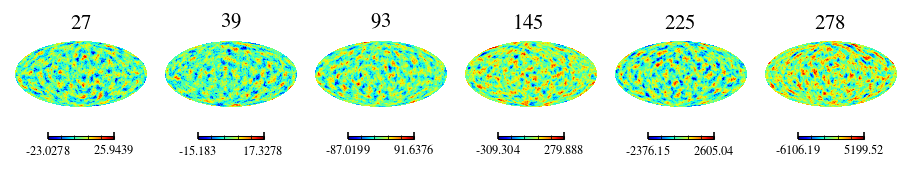

In [12]:
#create noise maps now
print('create noise maps now')
noise_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    print(freq)
    beamval, noiseval = beam_noise_dic['T'][freq]
    print(min(nl_dic['T'][freq]), max(nl_dic['T'][freq]))
    noise_map = H.synfast(nl_dic['T'][freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    noise_map_dic[freq] = noise_map
    H.mollview(noise_map, title = r'%s' %(freq), sub = (1,len(freqarr),fcnt+1), title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)

In [13]:
#create radio skies now from SPT-SZ measurements
print('create radio Gaussian skies now from SPT-SZ measurements')
random_seed_fg = 100 ##abs(int(cmb_map[0]))+1 ##834872
print('Random seed is %s' %(random_seed_fg))
fg_radio_dic = {}
for fcnt, freq in enumerate( freqarr ):
    print(freq)
    np.random.seed( random_seed_fg ) #correalted foregrounds
    radio_map = H.synfast(cl_radio_dic[freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)

    #Smooth
    beamval, noiseval = beam_noise_dic['T'][freq]
    radio_map = H.smoothing(np.copy(radio_map), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)
    
    fg_radio_dic[freq] = radio_map  
    #H.mollview(radio_map, title = r'%s' %(freq), sub = (1,len(freqarr),fcnt+1), title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)

create radio Gaussian skies now from SPT-SZ measurements
Random seed is 100
27
39
93
145
225
278


In [14]:
#read CUmilta/Yomori sims now
print('read CUmilta/YOmori sims now')
fg_cmb_dic = {}
for fcnt, freq in enumerate( freqarr ):
    print(freq)
    fg_cmb_mapname = '%s/%03d_nside2048.fits' %(fg_cmb_folder, fg_cmb_freq_dic[freq])
    fg_cmb_map = H.read_map(fg_cmb_mapname, verbose=verbose)
    if H.get_nside(fg_cmb_map) != param_dict['nside']:
        fg_cmb_map = H.ud_grade(fg_cmb_map, nside_out = param_dict['nside'])
    fg_cmb_dic[freq] = fg_cmb_map
    #H.mollview(fg_cmb_map, title = r'%s' %(freq), sub = (1,len(freqarr),fcnt+1), title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)

read CUmilta/YOmori sims now
27
39
93
145
225
278


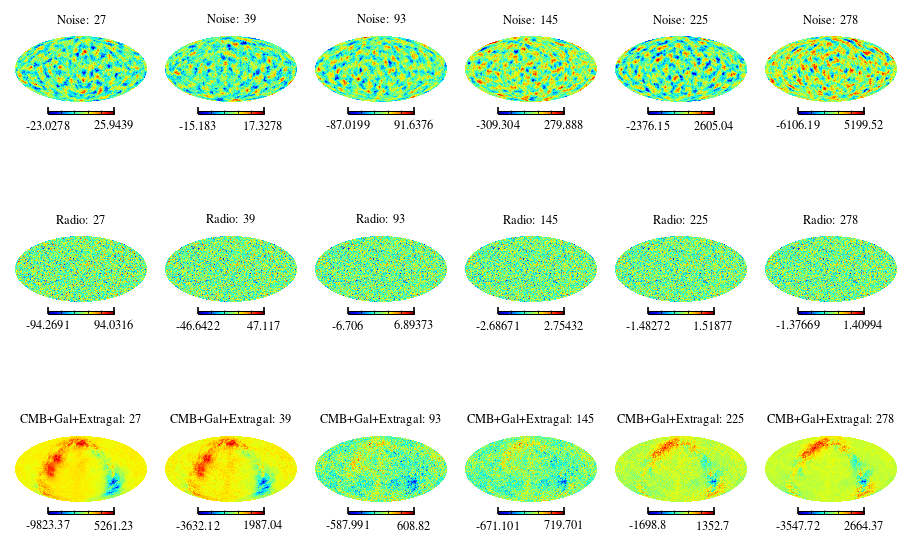

In [15]:
#show maps
tit_fsval = 6
vmin, vmax = None, None ##-300, 300.
for fcnt, freq in enumerate( freqarr ):
    H.mollview(noise_map_dic[freq], title = r'Noise: %s' %(freq), sub = (3,len(freqarr),fcnt+1), min = vmin, max = vmax, title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)
for fcnt, freq in enumerate( freqarr ):
    H.mollview(fg_radio_dic[freq], title = r'Radio: %s' %(freq), sub = (3,len(freqarr),fcnt+len(freqarr)+1), min = vmin, max = vmax, title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)
for fcnt, freq in enumerate( freqarr ):
    H.mollview(fg_cmb_dic[freq], title = r'CMB+Gal+Extragal: %s' %(freq), sub = (3,len(freqarr),fcnt+2*len(freqarr)+1), min = vmin, max = vmax, title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


[0. 0. 0. ... 0. 0. 0.] 0.4579625129699707


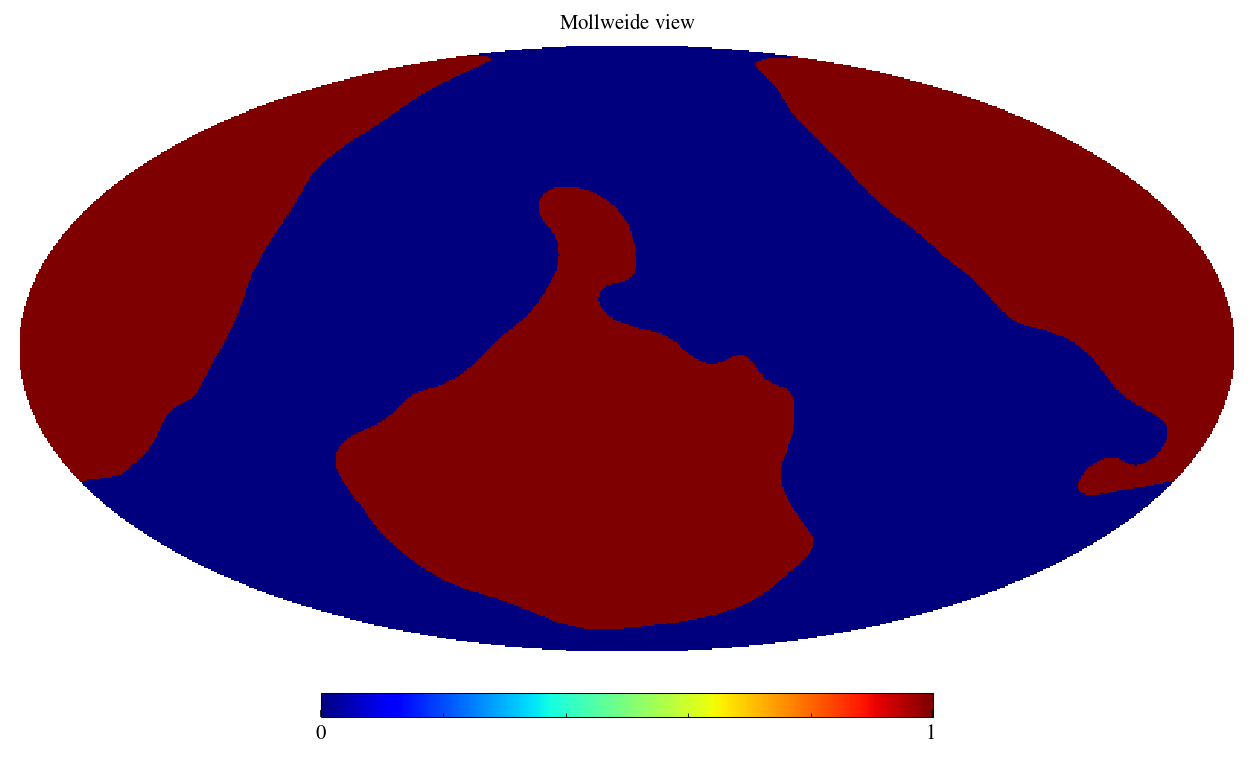

In [67]:
#using planck mask
planck_mask_fname = '%s/HFI_PowerSpect_Mask_2048_R1.10.fits' %(fg_cmb_folder)
planck_mask = H.read_map(planck_mask_fname, verbose = verbose)
if H.get_nside(planck_mask) != param_dict['nside']:
    planck_mask = H.ud_grade(planck_mask, nside_out = param_dict['nside'])
#simple rotattion from gal to celestial
planck_mask = misc.healpix_rotate_coords(planck_mask, coord = ['G', 'C'])
planck_mask = H.smoothing(np.copy(planck_mask), fwhm = np.radians(10.), lmax = param_dict['lmax'], verbose = verbose)
thresh = 0.4
planck_mask[planck_mask<thresh] = 0.
planck_mask[planck_mask!=0] = 1.
H.mollview(planck_mask)
print(planck_mask, np.mean(planck_mask))

In [68]:
#create combined maps now
map_dic = {}
for freq in freqarr:
    #combine CMB and FG
    cmb_fg_map_this_freq = np.copy( fg_radio_dic[freq] + fg_cmb_dic[freq] )
    
    '''
    #Smooth
    beamval, noiseval = beam_noise_dic['T'][freq]
    cmb_fg_map_this_freq = H.smoothing(np.copy(cmb_fg_map_this_freq), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)
    '''

    #add noise map to it
    map_dic[freq] = np.copy( cmb_fg_map_this_freq + noise_map_dic[freq] )
    
    #apply planck gal mask
    map_dic[freq] = map_dic[freq] * planck_mask
    

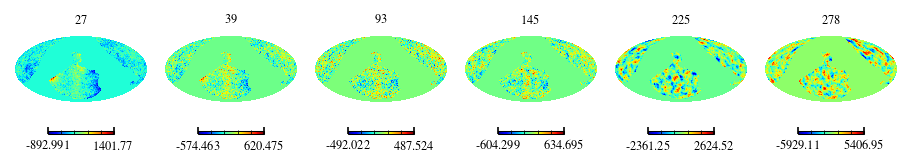

In [69]:
#show maps
for cntr, freq in enumerate( freqarr ):
    H.mollview(map_dic[freq], sub = (1, len(freqarr), cntr + 1), title = freq, title_fontsize = tit_fsval, cbar_label_fontsize = cbar_fsval, cbar_fontsize=cbar_fsval)

In [70]:
#get map covariance now
el, cl_dic = ilc.get_map_covariance(map_dic, param_dict['lmax'], apod_mask= planck_mask)
print(cl_dic.keys())

Estimating covariance from maps now
(27, 27)
(39, 27)
(93, 27)
(145, 27)
(225, 27)
(278, 27)
(39, 39)
(93, 39)
(145, 39)
(225, 39)
(278, 39)
(93, 93)
(145, 93)
(225, 93)
(278, 93)
(145, 145)
(225, 145)
(278, 145)
(225, 225)
(278, 225)
(278, 278)
dict_keys([(27, 27), (27, 39), (27, 93), (27, 145), (27, 225), (27, 278), (39, 27), (39, 39), (39, 93), (39, 145), (39, 225), (39, 278), (93, 27), (93, 39), (93, 93), (93, 145), (93, 225), (93, 278), (145, 27), (145, 39), (145, 93), (145, 145), (145, 225), (145, 278), (225, 27), (225, 39), (225, 93), (225, 145), (225, 225), (225, 278), (278, 27), (278, 39), (278, 93), (278, 145), (278, 225), (278, 278)])


2500


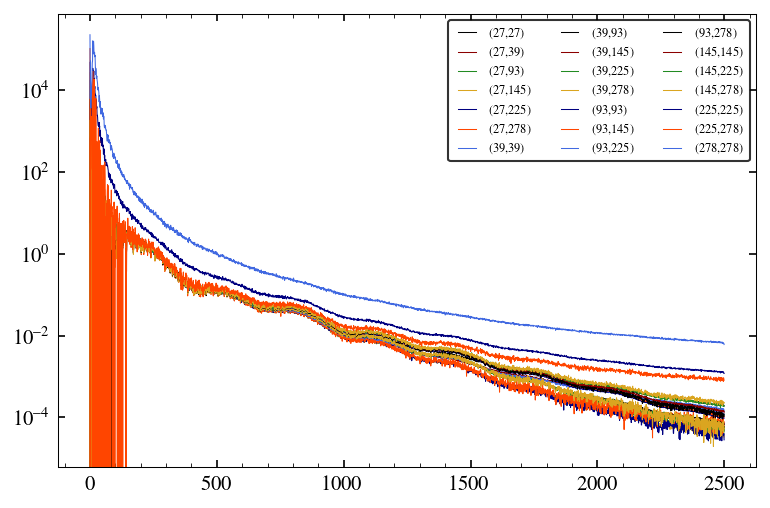

In [71]:
print(len(el))
#plot covariances
already_plotted = []
for freq1 in freqarr:
    for freq2 in freqarr:
        ax = subplot(1, 1, 1, yscale = 'log')
        if (freq2, freq1) in already_plotted: continue
        plot(el, cl_dic[(freq1, freq2)], label = r'(%s,%s)' %(freq1, freq2), lw = 0.5)
        legend(loc = 1, fancybox  = 1, fontsize = 6, ncol = 3)
        already_plotted.append( (freq1, freq2) )

        '''
        if (freq1, freq2) == (95, 95):
            sbpl = 1
        elif (freq1, freq2) == (145, 145):
            sbpl = 2
        elif (freq1, freq2) == (220, 220):
            sbpl = 3
        elif (freq1, freq2) == (270, 270):
            sbpl = 4
        elif (freq1, freq2) == (145, 95) or (freq1, freq2) == (95, 145):
            sbpl = 5
        elif (freq1, freq2) == (220, 95) or (freq1, freq2) == (95, 220):
            sbpl = 6
        elif (freq1, freq2) == (270, 95) or (freq1, freq2) == (95, 270):
            sbpl = 7
        elif (freq1, freq2) == (220, 145) or (freq1, freq2) == (145, 220):
            sbpl = 9
        elif (freq1, freq2) == (270, 145) or (freq1, freq2) == (145, 270):
            sbpl = 10
        elif (freq1, freq2) == (220, 270) or (freq1, freq2) == (270, 220):
            sbpl = 13
        else:
            continue
        print(freq1, freq2, sbpl)
        ax = subplot(4, 4, sbpl, yscale = 'log')
        plot(el, cl_dic[(freq1, freq2)], label = r'(%s,%s)' %(freq1, freq2), lw = 0.5)
        legend(loc = 1, fancybox  = 1, fontsize = 4)
        '''        

In [72]:
#get ILC map now
ilc_map, weightsarr = ilc.get_ilc_map(final_comp, el, map_dic, bl_dic, param_dict['nside'], param_dict['lmax'], cl_dic = cl_dic, lmin = param_dict['lmin'], estimate_covariance = 1, full_sky = 1, apod_mask= planck_mask)

(-5.0, 5.0)

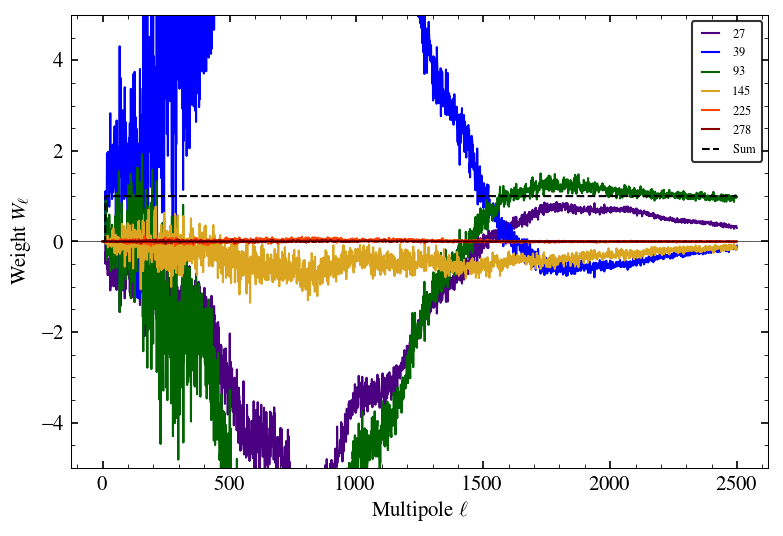

In [73]:
#plot weights now
for frqcntr, freq in enumerate( freqarr ):
    plot(weightsarr[frqcntr], color = colordic[freq], label = r'%s' %(freq))
plot(np.sum(weightsarr, axis = 0), 'k--', label = r'Sum')
axhline(lw=0.3)
legend(loc = 1, fontsize = 6)
xlabel(r'Multipole $\ell$')
ylabel(r'Weight $W_{\ell}$')
ylim(-5., 5.)

In [74]:
'''
#show maps
for cntr, freq in enumerate( freqs ):
    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    
H.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')
H.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')
#H.mollview(ilc_map, title = r'ILC')
'''

"\n#show maps\nfor cntr, freq in enumerate( freqs ):\n    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    \nH.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')\nH.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')\n#H.mollview(ilc_map, title = r'ILC')\n"

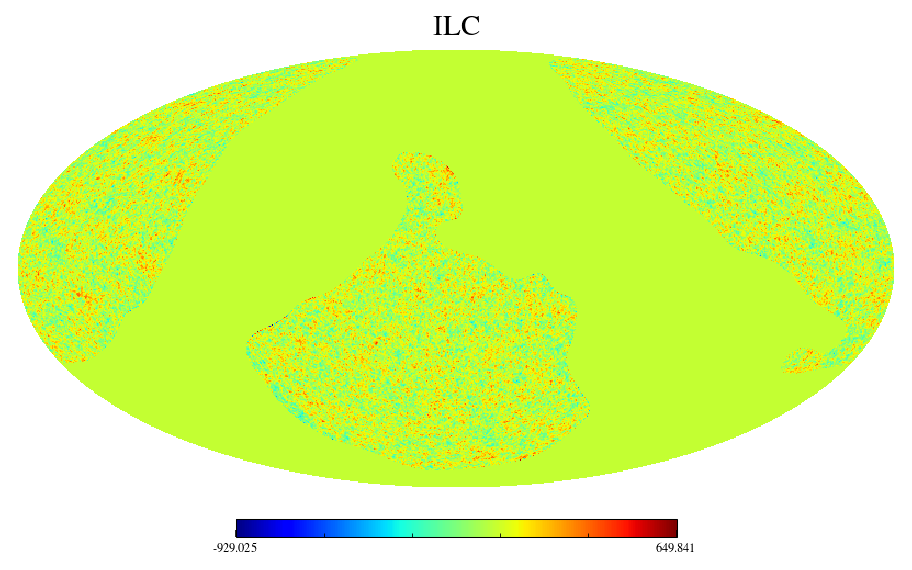

In [75]:
#H.mollview(cmb_map_input, sub = (1,2,1), title = r'Input')
H.mollview(ilc_map, sub = (111), title = r'ILC', title_fontsize=14, cbar_fontsize= cbar_fsval, cbar_label_fontsize= cbar_fsval)

In [76]:
#CMB imput map smoothed
#cmb_map_input_smoothed = H.smoothing(np.copy(cmb_map_input), fwhm = np.radians(opbeam/60.), lmax = lmax, verbose = verbose)

In [77]:
#Cls of input and output
Cls_ilc_ori = H.anafast(ilc_map, lmax = lmax) / np.mean(planck_mask)
#Cls_150_ori = H.anafast(map_dic[145], lmax = lmax)
#Cls_cross_ip_op_ori = H.anafast(cmb_map_input_smoothed, ilc_map, lmax = lmax)

In [78]:
#add beams
Cls_ilc = np.copy(Cls_ilc_ori[:lmax])
#Cls_150 = np.copy(Cls_150_ori[:lmax])
#Cls_cross_ip_op = np.copy(Cls_cross_ip_op_ori[:lmax])

Cls_ilc = Cls_ilc / bl_dic['effective']**2.
#Cls_150 = Cls_150 / bl_dic[145]**2.
#Cls_cross_ip_op = Cls_cross_ip_op / bl_dic['effective']**2.

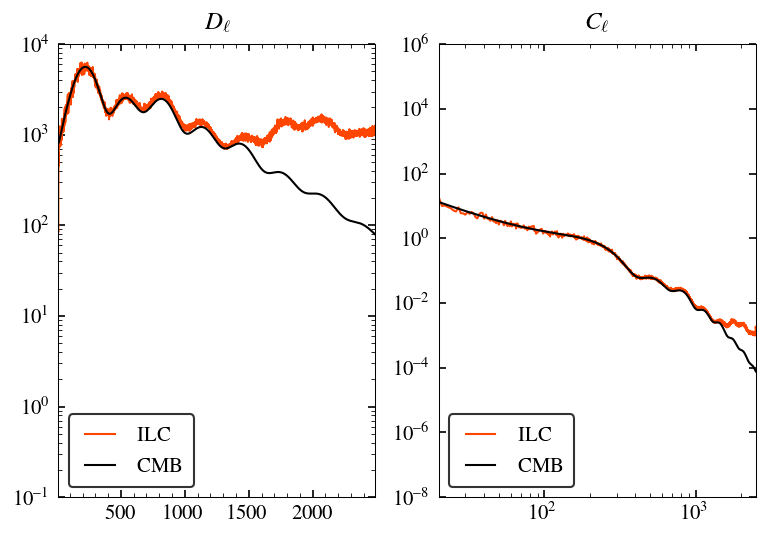

In [79]:
for iter in range(2):
    if iter == 0:
        ax = subplot(1,2,iter+1, yscale = 'log')#, xscale = 'log')
    else:
        ax = subplot(1,2,iter+1, yscale = 'log', xscale = 'log')
    els_ = np.arange(len(Cls_ilc))
    if iter == 0:
        Dls_fac = (els_ * (els_ + 1)) / 2 / np.pi
    else:
        Dls_fac = 1.
    plot(Dls_fac * Cls_ilc, 'orangered', label = r'ILC')
    #plot(Dls_fac * Cls_150, 'purple', label = r'150 GHz')
    #plot(Dls_fac * Cls_cross_ip_op, 'limegreen', label = r'Input $\times$ ILC')

    if iter == 0:
        Dls_fac = (el_camb * (el_camb + 1)) / 2 / np.pi
    else:
        Dls_fac = 1.
    plot(el_camb, Dls_fac * cl_TT, 'k-', label = r'CMB')

    legend(loc=3)
    if iter == 0:
        title(r'$D_{\ell}$')
        xlim(param_dict['lmin'], param_dict['lmax']-10); ylim(1e-1, 1e4)
    else:
        title(r'$C_{\ell}$')
        xlim(20,lmax);ylim(1e-8,1e6);